### Test the final model (LR, AP3 + agent feature FP) by Y-scrambling and with external test set A

In [1]:
import gzip
import _pickle as cPickle
from collections import defaultdict
import random
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import utilsFunctions
import numpy as np
from pylab import rcParams

Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

In [3]:
dataDir = "../data/"

with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)
# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

Load the AP3 and agent feature fingerprint

In [45]:
infile = gzip.open(dataDir+"transformationFPs_MG2_agentFPs_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_AP3,fp_agentFeature, fp_agentMG2 = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_AP3,fp_agentFeature])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000


In [46]:
lineNo

49883

Split the FPs in training (20 %) and test data (80 %) per recation type (200, 800)

In [47]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
fpsz=256
trainFps_AP3_agentFeature=[]
trainActs=[]
testFps_AP3_agentFeature=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        np1 = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        trainFps_AP3_agentFeature += [np.concatenate([np1, np2])]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        np1 = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        testFps_AP3_agentFeature += [np.concatenate([np1, np2])]
    testActs += [i]*nTest

building fp collection


Test y-scrambling of our training data

In [6]:
import copy

lr_cls =  LogisticRegression(solver='liblinear')
# lr_cls =  LogisticRegression(solver='newton-cg')

trainActs_temp = copy.deepcopy(trainActs)
random.seed(42)
random.shuffle(trainActs_temp)
result_lr_cls = lr_cls.fit(trainFps_AP3_agentFeature,trainActs_temp)

Evaluate the y-scrambled model

In [7]:
cmat_fp_AP3_feature = utilsFunctions.evaluateModel(result_lr_cls, testFps_AP3_agentFeature, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.0213  0.0210  0.0211     1.2.1 Aldehyde reductive amination
 1  0.0063  0.0085  0.0072     1.2.4 Eschweiler-Clarke methylation
 2  0.0475  0.0545  0.0508     1.2.5 Ketone reductive amination
 3  0.0138  0.0179  0.0156     1.3.6 Bromo N-arylation
 4  0.0213  0.0146  0.0173     1.3.7 Chloro N-arylation
 5  0.0075  0.0083  0.0079     1.3.8 Fluoro N-arylation
 6  0.0088  0.0078  0.0082     1.6.2 Bromo N-alkylation
 7  0.0037  0.0042  0.0040     1.6.4 Chloro N-alkylation
 8  0.0262  0.0380  0.0311     1.6.8 Iodo N-alkylation
 9  0.0288  0.0277  0.0282     1.7.4 Hydroxy to methoxy
10  0.0675  0.0706  0.0690     1.7.6 Methyl esterification
11  0.0025  0.0016  0.0019     1.7.7 Mitsunobu aryl ether synthesis
12  0.0175  0.0203  0.0188     1.7.9 Williamson ether synthesis
13  0.0025  0.0024  0.0025     1.8.5 Thioether synthesis
14  0.0163  0.0182  0.0172    10.1.1 Bromination
15  0.0262  0.0251  0.0256    10.1.2 Chlorination
16  0.0013  0.0012

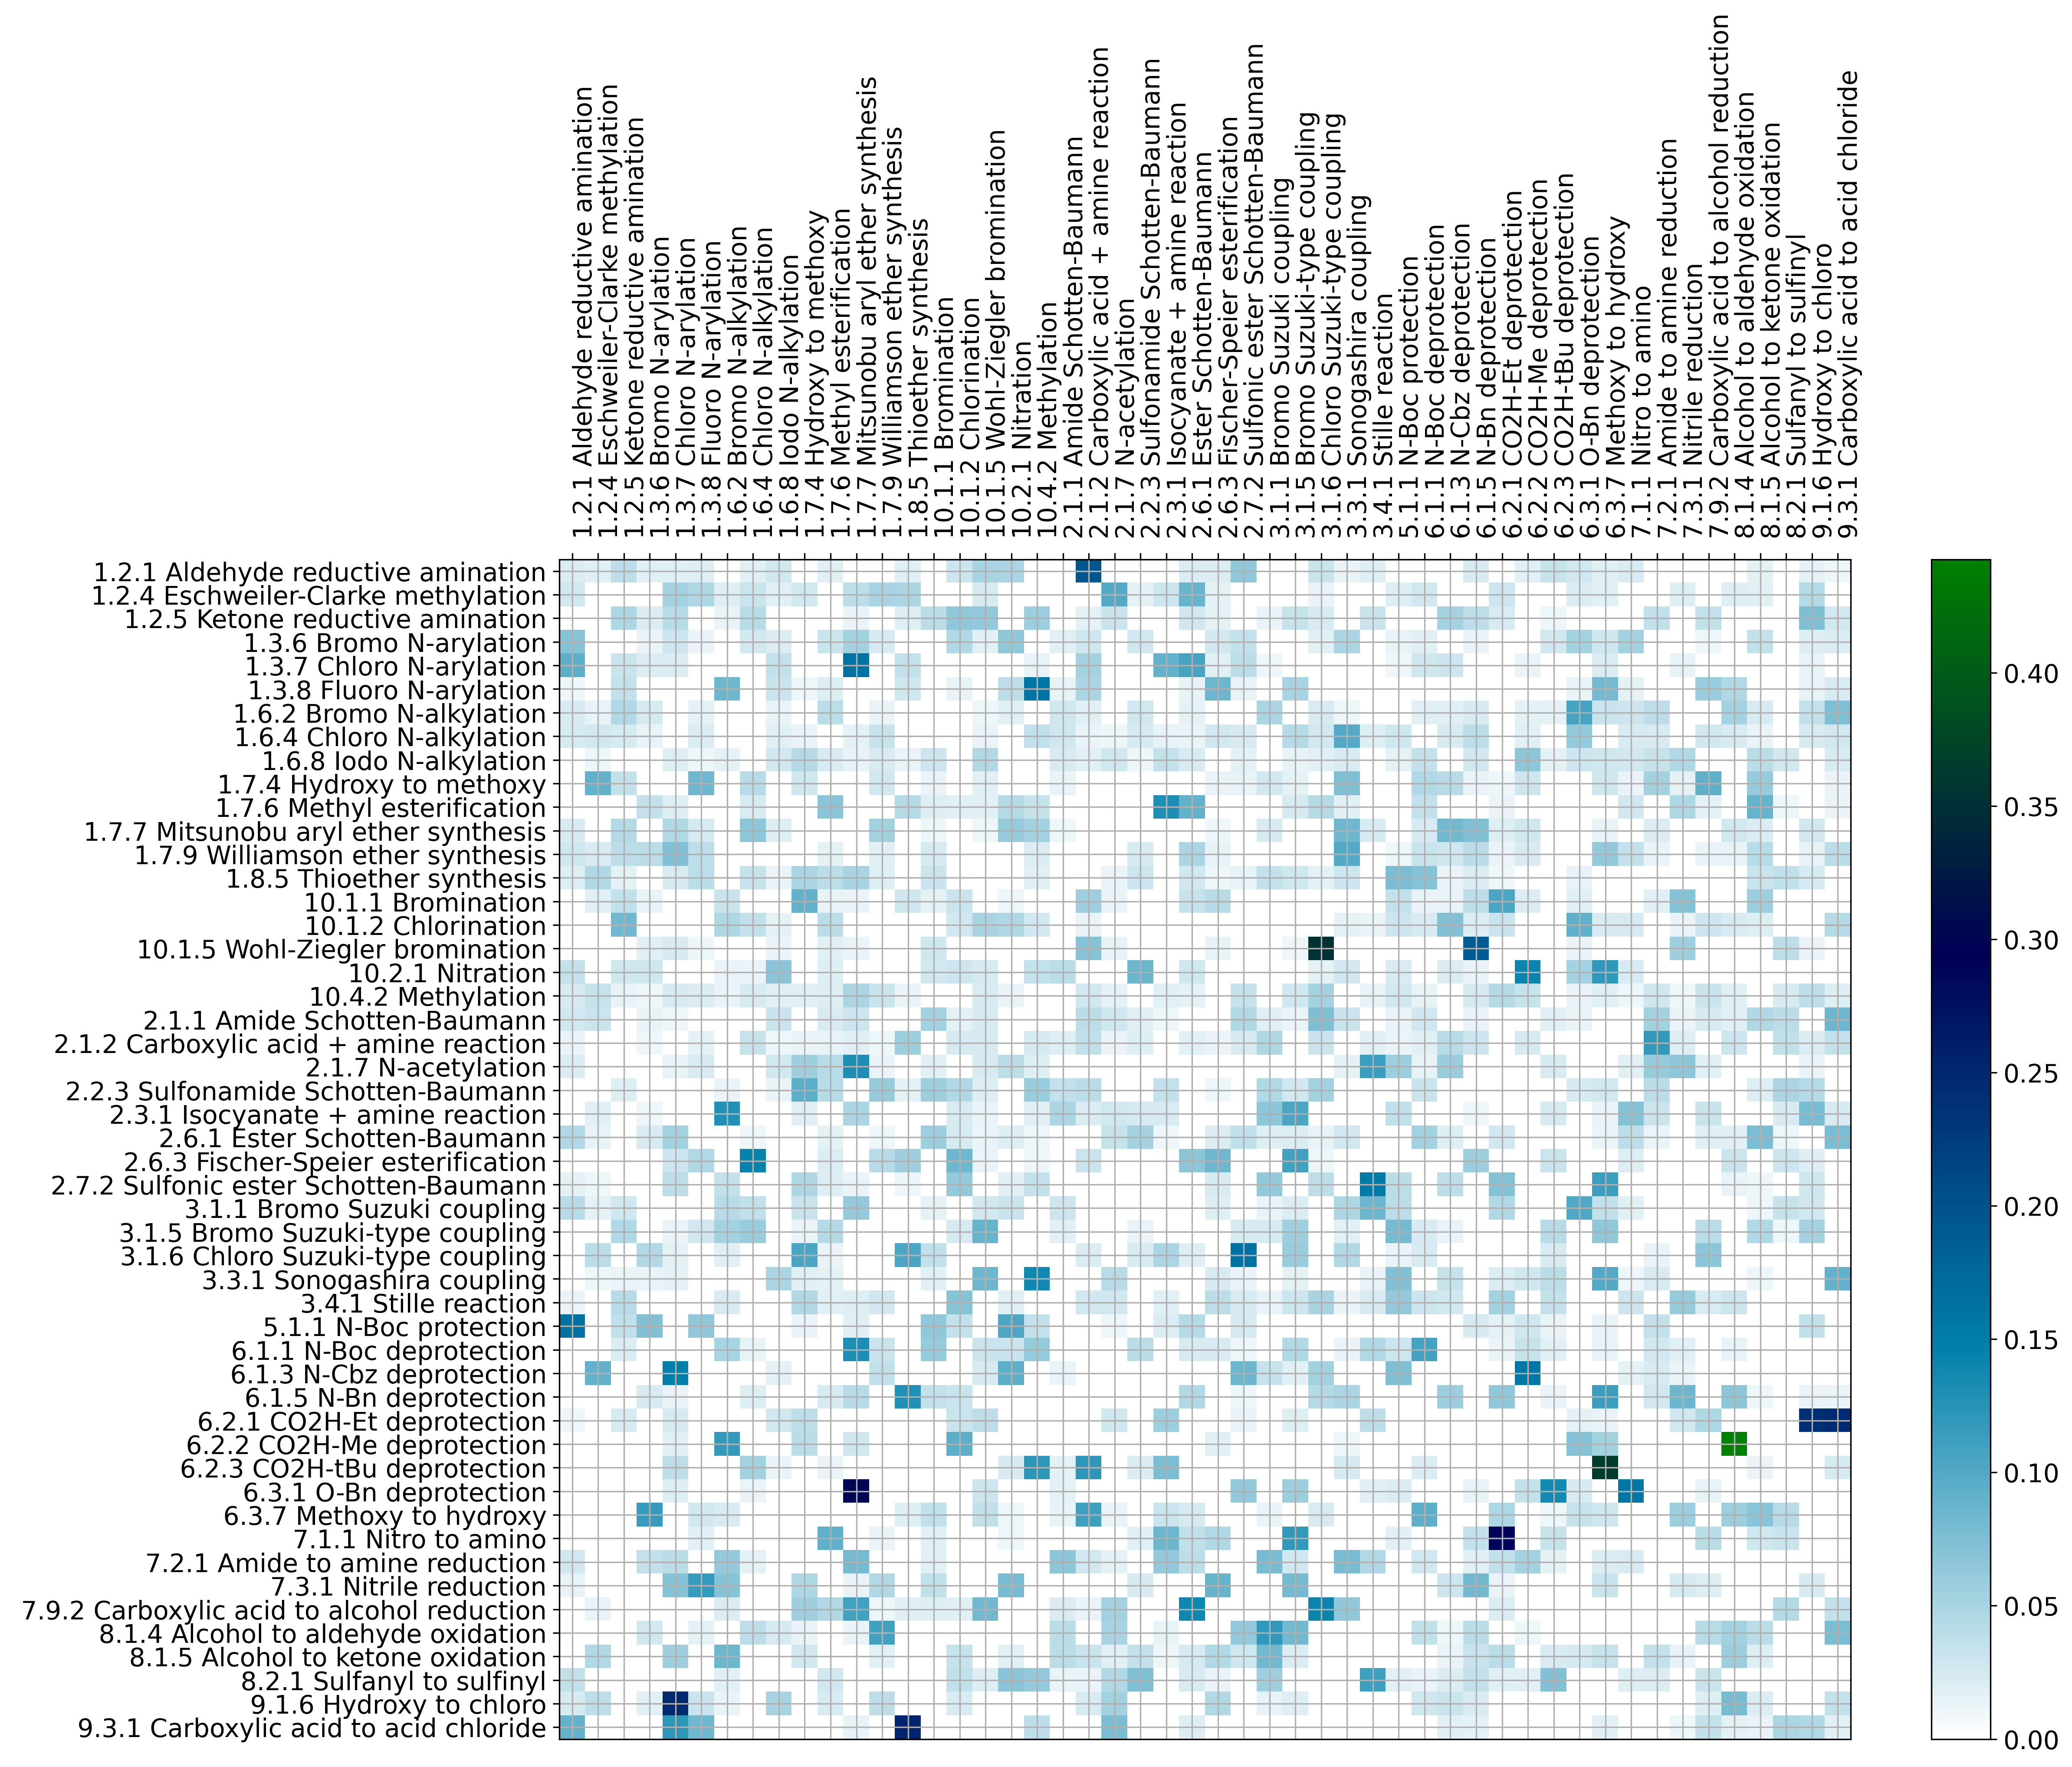

In [8]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_feature,rtypes,figsize=(16,12), labelExtras=names_rTypes)

#### Build the final model and save

In [48]:
print('training model')
lr_cls =  LogisticRegression(penalty='l1', random_state = 100, solver = 'liblinear', max_iter = 1000)
# lr_cls =  LogisticRegression(solver = 'sag')
result_lr_cls = lr_cls.fit(trainFps_AP3_agentFeature,trainActs)

training model


In [49]:
cmat_fp_AP3_feature = utilsFunctions.evaluateModel(result_lr_cls, testFps_AP3_agentFeature, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9775  0.9775  0.9775     1.2.1 Aldehyde reductive amination
 1  0.9850  0.9645  0.9746     1.2.4 Eschweiler-Clarke methylation
 2  0.9738  0.9811  0.9774     1.2.5 Ketone reductive amination
 3  0.9688  0.9556  0.9621     1.3.6 Bromo N-arylation
 4  0.9637  0.9542  0.9590     1.3.7 Chloro N-arylation
 5  0.9775  0.9775  0.9775     1.3.8 Fluoro N-arylation
 6  0.9363  0.9590  0.9475     1.6.2 Bromo N-alkylation
 7  0.9313  0.9539  0.9424     1.6.4 Chloro N-alkylation
 8  0.9025  0.8699  0.8859     1.6.8 Iodo N-alkylation
 9  0.9725  0.9240  0.9476     1.7.4 Hydroxy to methoxy
10  0.9750  0.9677  0.9714     1.7.6 Methyl esterification
11  0.9275  0.9611  0.9440     1.7.7 Mitsunobu aryl ether synthesis
12  0.9413  0.9605  0.9508     1.7.9 Williamson ether synthesis
13  0.9875  0.9900  0.9887     1.8.5 Thioether synthesis
14  0.9125  0.9493  0.9305    10.1.1 Bromination
15  0.9563  0.9647  0.9605    10.1.2 Chlorination
16  0.9688  0.9515

Store the model as scikit-learn model

In [50]:
import joblib

In [51]:
joblib.dump(result_lr_cls, dataDir+'LR_transformationFP256bit.AP3.agent_featureFP.pkl') 

['../data/LR_transformationFP256bit.AP3.agent_featureFP.pkl']

#### Load the new model and test on external test set A

In [36]:
clf = joblib.load(dataDir+'LR_transformationFP256bit.AP3.agent_featureFP.pkl')

Test the final model (LR, AP3 256 bit + agent featureFP) with external test set A (another 50000 reactions randomly selected form the patent data)

Load the FPs

In [37]:
infile = gzip.open(dataDir+"transformationFPs_agentFPs_external_test_set_A.pkl.gz", 'rb')
lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_AP3,fp_agentFeature = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_AP3,fp_agentFeature])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


Combine the FPs of the external test set

In [38]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

fpsz=256

testFps_AP3_agentFeature=[]
testActs=[]
print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    nTest=len(actIds)
    for x in actIds:
        np1 = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        testFps_AP3_agentFeature += [np.concatenate([np1, np2])]
    testActs += [i]*nTest

building fp collection


Evaluate the model performance

In [39]:
cmat_fp_AP3_feature = utilsFunctions.evaluateModel(clf, testFps_AP3_agentFeature, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9890  0.9715  0.9802     1.2.1 Aldehyde reductive amination
 1  0.9890  0.9677  0.9782     1.2.4 Eschweiler-Clarke methylation
 2  0.9840  0.9870  0.9855     1.2.5 Ketone reductive amination
 3  0.9810  0.9599  0.9703     1.3.6 Bromo N-arylation
 4  0.9760  0.9683  0.9721     1.3.7 Chloro N-arylation
 5  0.9890  0.9910  0.9900     1.3.8 Fluoro N-arylation
 6  0.9590  0.9776  0.9682     1.6.2 Bromo N-alkylation
 7  0.9340  0.9550  0.9444     1.6.4 Chloro N-alkylation
 8  0.8860  0.8755  0.8807     1.6.8 Iodo N-alkylation
 9  0.9810  0.9272  0.9534     1.7.4 Hydroxy to methoxy
10  0.9670  0.9689  0.9680     1.7.6 Methyl esterification
11  0.9360  0.9640  0.9498     1.7.7 Mitsunobu aryl ether synthesis
12  0.9510  0.9784  0.9645     1.7.9 Williamson ether synthesis
13  0.9850  0.9762  0.9806     1.8.5 Thioether synthesis
14  0.9320  0.9658  0.9486    10.1.1 Bromination
15  0.9470  0.9683  0.9575    10.1.2 Chlorination
16  0.9850  0.9363

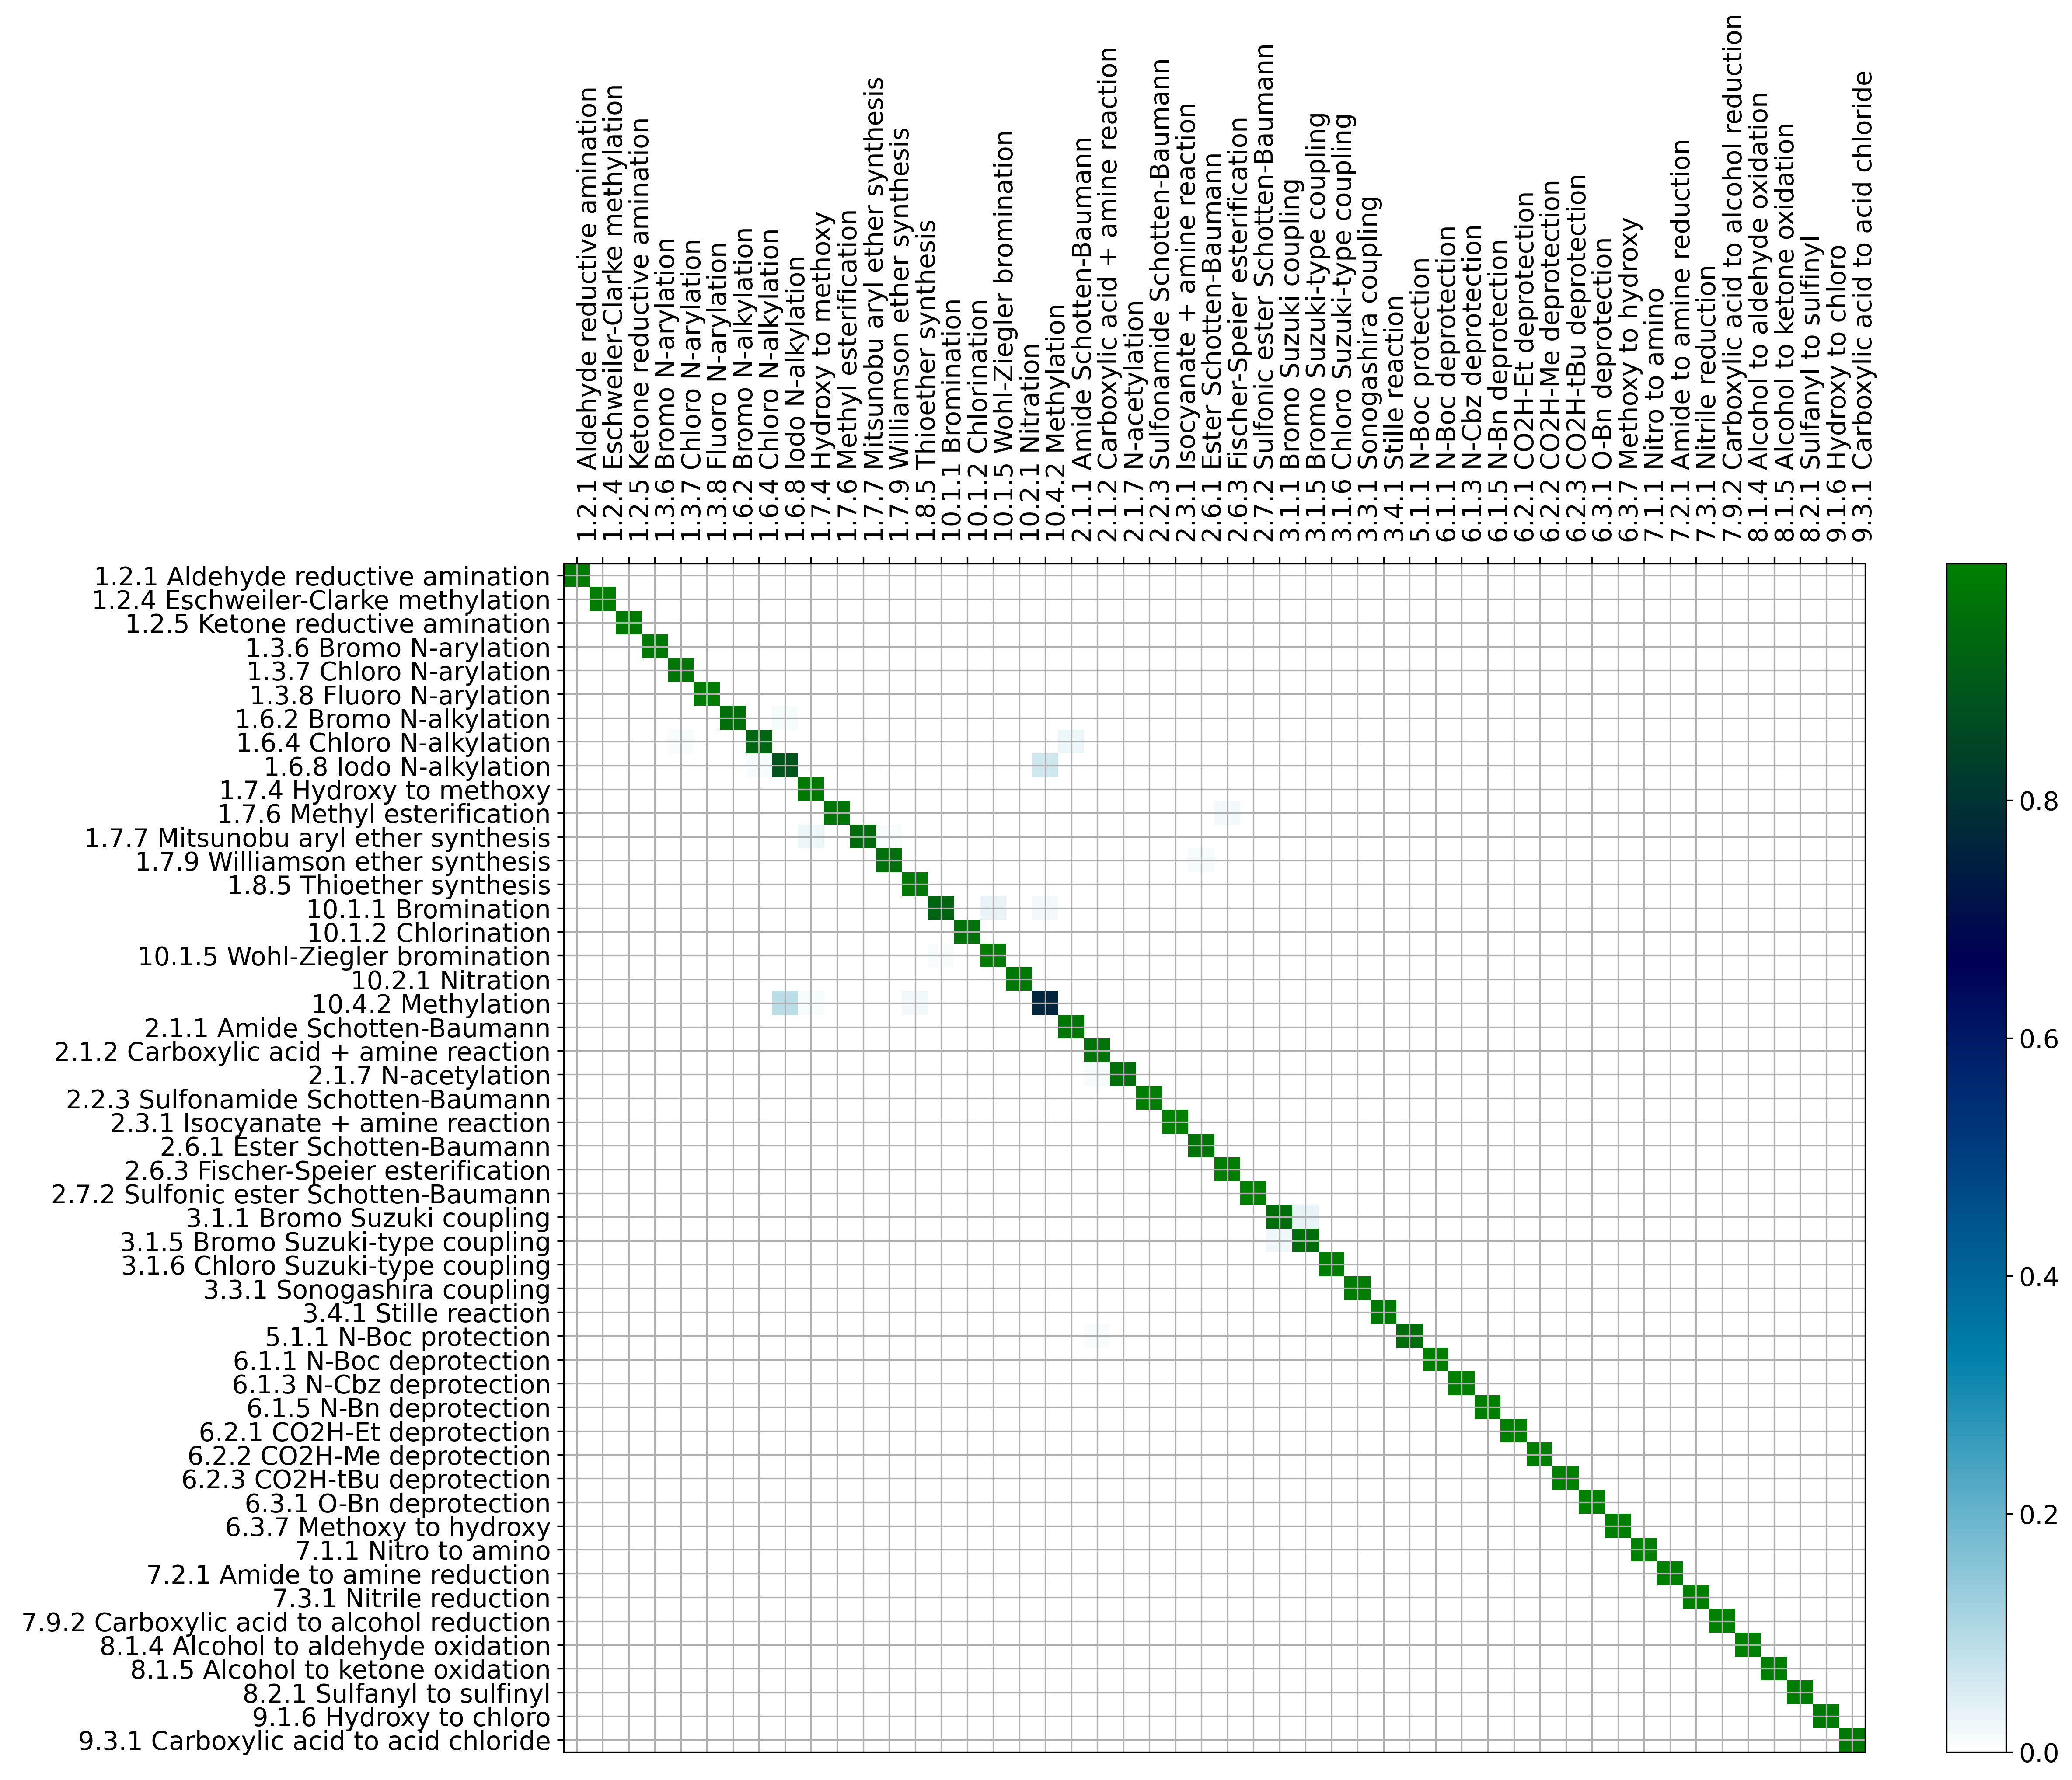

In [22]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_feature,rtypes,figsize=(16,12), labelExtras=names_rTypes)